# Introduction

This is a comparison of the SETI@home doppler drift code against the phython code.

First some helper code...  This returns the barycentric velocity correction in a specific direction.

In [1]:
# corrs.py
import math
import numpy as np
from astropy.time import Time
from astropy.coordinates import SkyCoord, solar_system, EarthLocation, ICRS, CartesianRepresentation, UnitSphericalRepresentation
from astropy import units as u
import pywu



def velcorr(time, skycoord, location=None):
  """Barycentric velocity correction.
  
  Uses the ephemeris set with  ``astropy.coordinates.solar_system_ephemeris.set`` for corrections. 
  For more information see `~astropy.coordinates.solar_system_ephemeris`.
  
  Parameters
  ----------
  time : `~astropy.time.Time`
    The time of observation.
  skycoord: `~astropy.coordinates.SkyCoord`
    The sky location to calculate the correction for.
  location: `~astropy.coordinates.EarthLocation`, optional
    The location of the observatory to calculate the correction for.
    If no location is given, the ``location`` attribute of the Time
    object is used
    
  Returns
  -------
  vel_corr : `~astropy.units.Quantity`
    The velocity correction to convert to Barycentric velocities. Should be added to the original
    velocity.
  """
  
  if location is None:
    if time.location is None:
        raise ValueError('An EarthLocation needs to be set or passed '
                         'in to calculate bary- or heliocentric '
                         'corrections')
    location = time.location
  
  ep, ev = solar_system.get_body_barycentric_posvel('earth', time) # ICRS position and velocity of Earth's geocenter
  op, ov = location.get_gcrs_posvel(time) # GCRS position and velocity of observatory
  # ICRS and GCRS are axes-aligned. Can add the velocities
  velocity = ev + ov # relies on PR5434 being merged
  14
  # get unit ICRS vector in direction of SkyCoord
  sc_cartesian = skycoord.icrs.represent_as(UnitSphericalRepresentation).represent_as(CartesianRepresentation)
  return sc_cartesian.dot(velocity).to(u.km/u.s) # similarly requires PR5434



The SETI@home code uses the Arecibo observatory corrdinates (both astronomical and geodetic).  This only has
one coordinate possible so we'll use the Arecibo geodetic coordinates.

In [2]:
AO=EarthLocation.of_site("Arecibo Observatory")
AO.geodetic


GeodeticLocation(lon=<Longitude -66.75277778 deg>, lat=<Latitude 18.34416667 deg>, height=<Quantity 497. m>)


Just a note that this doesn't match the geodetic coordinates that I've been using, which proably means that they are using a different ellipsoid than I use.  It shouldn't make a difference if everything is consistent.  It is also different than the Astronomical coordinates used for determining where Arecibo was pointing.  The gravitational acceleration is not perpendicular to the ellipsoid at Arecibo.  This is also likely to be true at FAST, but it is my understanding that at FAST the direction of the gravity is ignored and geodetic coordinates are used for astronomical positions.

Next we need something to look at, and a time.  I've pulled the 1 billionth workunit generated for SETI@home and am taking its time and coordinates
JD=2455628.794039 RA(hours)=13.65615430833, Dec(deg)=33.23895434779

In [3]:
pos=SkyCoord(13.65615430833*15,33.23895434779,unit="deg",equinox="J2000",obstime=Time(2455628.794039,format="jd",location=AO))
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (204.84231462, 33.23895435)>

In [4]:
pos.obstime

<Time object: scale='utc' format='jd' value=2455628.794039>

OK, now lets get the barycentric correction

In [5]:
corr=velcorr(pos.obstime,pos)
corr

<Quantity 8.41758242 km / s>

So according to the comments, this is the correction the velocity of an astronomical object.  So if a star was measured to have a radial velocity of zero, its corrected velocity would be +8.4 km/s with respect to the barycenter and we would expect its observed radio frequency to be $\frac{c+8.4\frac{\rm km}{\rm s}}{c} \nu_o$ where $\nu_o$ is the emitted frequency.  In other words the observed emission is blue shifted.  So for an emitted frequency of 1.420 GHz, the observed frequency would be....

In [6]:
c=299792458*u.meter/u.second
nu_corr=math.sqrt((1+corr/c)/(1-corr/c))
nu=1.420e+9*u.Hz
nu1=nu*nu_corr
nu1.decompose().to_string(precision=14)


'1.42003987136610e+09 1 / s'

If we want the doppler drift rate due to the motion of the earth we need to do the same calculation before an after the point.


In [7]:
#two points a second apart
corr0=velcorr(pos.obstime-0.5*u.second,pos)
corr1=velcorr(pos.obstime+0.5*u.second,pos)
nu_corr0=math.sqrt((1+corr0/c)/(1-corr0/c))
nu_corr1=math.sqrt((1+corr1/c)/(1-corr1/c))
drift=nu*(nu_corr1-nu_corr0)/u.second
drift.decompose()


<Quantity -0.14821716 1 / s2>

Since the doppler drift is dominated by the Earth's rotation which is an acceleration toward the axis, and telescopes usually point up, the drift rate will almost always be negative.

Now lets compare the SETI@home doppler code.  The program to calculate an observed frequency from a barycentric frequency is called "detection_frequency"

> % ./detection_freq -jd 2455628.794039 -ra 13.65615430833 -decl 33.23895434779 -baryfreq 1420000000 -epoch 2000.0

> JD 2455628.794039 LST 13.649352 RA 13.656154 Declination 33.238954 detection frequency 1420039875.533216 barycentric frequency 1420000000.000000 offset (bary-det) -39875.533216 barycentric chirp -0.148083


So there are some small differences in the acceleration model used.  Frequencies differ by 5 Hz and drift rates by a part in $10^{-4}$.  That shouldn't be big enough to cause a problem because our detection windows are much larger than that.  So we should be able to use the astropy routines.


# Application to a Work Unit

I've put a workunit in the directory with this called "work_unit.sah."  We'll read it and use the appropriate fields to calculate the
barycentric doppler drift rate of the observation... 

Someone needs to write a function that will read a workunit and all it's parameters...  Since that doesn't yet exist
we will look at the parameters manually.


Does astropy have the FAST coordinates correct?  This should match what is in the workunit header.

In [8]:
FAST=EarthLocation.of_site("FAST")
FAST.geodetic

GeodeticLocation(lon=<Longitude 106.85666642 deg>, lat=<Latitude 25.65294616 deg>, height=<Quantity 1109.10232229 m>)

In [9]:
import xml.etree.ElementTree as ET

def xml2dict(x):
    """
    Description:
        Convert xml to dict.
    Inputs:
        - x(xml.etree.ElementTree.Element): xml element
    Outputs:
        - d(dict): dict
    """
    d = {}
    for i in range(len(x)):
        if len(x[i]) == 0:
            try:
                d[x[i].tag] = float(x[i].text)
            except:
                d[x[i].tag] = x[i].text
        elif x[i].tag in d.keys():
            # if the key is already in the dict,
            # convert it to list
            if type(d[x[i].tag]) == dict:
                d[x[i].tag]= [d[x[i].tag]]
            d[x[i].tag].append(xml2dict(x[i]))
        else:
            d[x[i].tag] = xml2dict(x[i])
    return d

def read_wu_header(fn):
    """
    Description:
        Generate workunit header.
    Inputs:
        - fn(str): workunit filename
    Outputs:
        - wuh(dict): workunit header
    """
    with open(fn, 'rb') as f:
        xmls = f.readlines()
    h = []
    for x in xmls:
        # skip the workunit tag
        if x == b'<workunit>\n':
            continue
        # if it's the end of workunit_header, exit
        elif x == b'  </workunit_header>\n' :
            h.append(x.decode('utf-8'))
            break
        else:
            h.append(x.decode('utf-8'))
    # convert list to string
    hstr = ''.join(h)
    # read xml
    r = ET.fromstring(hstr)
    # convert xml to dict
    wuh = {}
    wuh[r.tag] = xml2dict(r)
    return wuh

def _get_data_info(infostr):
    """
    Description:
        Get data info from infostr.
        The format has to be like '  <data length=61034 encoding="sun_binary">\n'
    Inputs:
        - infostr(str): info string
    Outputs:
        - info(dict): data info
    """
    info = {}
    s = infostr.split('=')
    info[s[0][3:]] = int(s[1].split(' ')[0])
    info[s[1].split(' ')[1]] = s[2][:-2]
    return info

def read_wu_data(fn):
    """
    Description:
        Generate workunit data.
    Inputs:
        - fn(str): workunit filename
    Outputs:
        - info(dict): data info
        - d(bytes): data
    """
    with open(fn, 'rb') as f:
        xmls = f.readlines()
    d = b''
    dflag = 0
    for x in xmls:
        # try to decode the byte to string
        try:
            xstr = x.decode('utf-8')
        except:
            pass
        # if it's the end of data, set dflag to 0
        if xstr.startswith('  </data>') and dflag == 1:
            dflag = 0
        # if it's the data, add it to d
        if dflag == 1:
            d = d + x
        # if it's the start of data, set dflag to 1
        if xstr.startswith('  <data length') and dflag == 0:
            dflag = 1
            info = _get_data_info(xstr)
    # convert to numpy format and decouple from the buffer.
    d=np.frombuffer(d,dtype=np.int8)
    d=d.copy()
    
 
    # Verify the length of data
    # there is a carrage return (0x0a) and maybe a line feed (0x13)
    # after the data section and a number of spaces (0x20) 
    # that could be variable.  We don't want to accidentally remove
    # data so we may have to restore some bytes
    # to get the correct length.
    removed=np.array([d[0]])
    removed=removed.copy()
    while ((d[-1] == 32) or (d[-1] == 10) or (d[-1] == 13)):
        removed=np.append(removed,[d[-1]])
        d.resize(len(d)-1,refcheck=False)
        
    while len(d) < 2*1024*1024:
        d=np.append(d,[removed[-1]])
        removed.resize(len(removed)-1,refcheck=False)
        
    return info, d, removed




Here's the workunit header


In [10]:
header=read_wu_header('work_unit.sah')
lat=header['workunit_header']['group_info']['receiver_cfg']['latitude']*u.degree
lon=header['workunit_header']['group_info']['receiver_cfg']['longitude']*u.degree
el=header['workunit_header']['group_info']['receiver_cfg']['elevation']*u.meter
print( lat, lon, el )

25.652944 deg 106.856667 deg 1110.0288 m



Slightly different...  Hmmm....  Possibly another difference between geodetic and geocentric coordinates, or possibly the model speroid used. How far apart are they?

In [11]:
math.sqrt((((FAST.geodetic.lon-lon).radian*63870000*u.meter)**2+
     ((FAST.geodetic.lat-lat).radian*63870000*u.meter)**2+
     (FAST.geodetic.height-el)**2)/u.meter**2)*u.meter

<Quantity 2.66404509 m>

Not a huge difference, so we'll call them the same.  If we were doing nanosecond timing or nanoHz spectroscopy, this might make a difference.

Now the sky position at the start and end of the workunit.


In [12]:
start_ra=header['workunit_header']['group_info']['data_desc']['start_ra']*15*u.degree
start_dec=header['workunit_header']['group_info']['data_desc']['start_dec']*u.degree
start_time=Time(header['workunit_header']['group_info']['data_desc']['time_recorded_jd'],format='jd')
print(start_ra,start_dec,start_time)

145.289505 deg 22.794722 deg 2460054.9744097223


In [13]:
pos0=SkyCoord(start_ra,start_dec,equinox="J2000",obstime=Time(start_time,location=FAST))
pos0

<SkyCoord (ICRS): (ra, dec) in deg
    (145.289505, 22.794722)>

The last position should be in the final set of coordinates.

In [14]:
coord=header['workunit_header']['group_info']['data_desc']['coords']['coordinate_t'][-1]

In [15]:
pos1=SkyCoord(coord['ra']*15,coord['dec'],unit="deg",equinox="J2000",obstime=Time(coord['time'],format="jd",location=FAST))
pos1

<SkyCoord (ICRS): (ra, dec) in deg
    (145.549785, 22.791361)>

In [16]:
corr0=velcorr(pos0.obstime,pos0)
corr0

<Quantity -27.25446507 km / s>

In [17]:
corr1=velcorr(pos1.obstime,pos1)
corr1

<Quantity -27.20668227 km / s>

The difference in time between these two observations is...

In [18]:
dur=(pos1.obstime-pos0.obstime).to_value('sec')*u.second
dur

<Quantity 69.59998459 s>

This should be equal to 1 Mi / subband_sample_rate

In [19]:
1024*1024/15258.7890625*u.second

<Quantity 68.71947674 s>

It's not, which probably indicates a possible problem with work unit generation, probably the last coordinate is after the end of data.  That should not bother the SETI@home client which interpolates between the coordinates to identify the end.  It should not affect this work either, but interpolation wouldn't hurt.

These are the barycentric corrections at the start and end of the observation.  Expressed as acceleration that is...

In [20]:
accel=(corr1-corr0)/dur
accel

<Quantity 0.00068653 km / s2>

Now find the frequency we are correcting for.  For this work we can only do one frequency per workunit, the central frequency.

    <center>1420364379.882812</center>

In [21]:
nu=1420364379.882812*u.Hz
nu

<Quantity 1.42036438e+09 Hz>

Noe we have to calculate the doppler drift over that time

In [22]:
#two points a second apart
nu_corr0=math.sqrt((1+corr0/c)/(1-corr0/c))
nu_corr1=math.sqrt((1+corr1/c)/(1-corr1/c))
drift=nu*(nu_corr1-nu_corr0)/dur
drift.decompose()


<Quantity 3.25238612 1 / s2>

Now you should be confused, because I said the Doppler drift would almost always be negative, and this value is larger than it should be and has the opposite sign that it should.

That's because I deliberately made a mistake that crops up a lot in SETI.  I've calculated the Doppler drift using two different coordinates.  So I've calculated the Doppler drift of an object moving across the sky at a constant distance.  That's not what we're looking for.  If I calculate
the doppler drift at the start and end position.  Lets start by defining a function for the Doppler drift.

In [23]:

def doppler_drift(pos, nu):
  corr0=velcorr(pos.obstime-0.5*u.second,pos)
  corr1=velcorr(pos.obstime+0.5*u.second,pos)
  nu_corr0=math.sqrt((1+corr0/c)/(1-corr0/c))
  nu_corr1=math.sqrt((1+corr1/c)/(1-corr1/c))
  drift=nu*(nu_corr1-nu_corr0)/u.second
  return drift


In [24]:
drift0=doppler_drift(pos0,nu)
drift0

<Quantity -0.1354733 Hz / s>

In [25]:
drift1=doppler_drift(pos1,nu)
drift1

<Quantity -0.13560293 Hz / s>

Those are better answers...  So the average drift rate over the workunit is:

In [26]:
drift=(drift0+drift1)/2
drift

<Quantity -0.13553812 Hz / s>

Now we need to grab the data from the file

In [27]:
info,data,removed=read_wu_data("work_unit.sah")

In [28]:
print(len(data))
print(np.mean(data))
print(np.std(data))

2097152
-0.024631977081298828
28.910991404271062


That second number should be 2097152.  The average should be near zero and the standard deviation around between 15 and 40 or so.

Let's normalize to the standard deviation and check the distribution of samples.

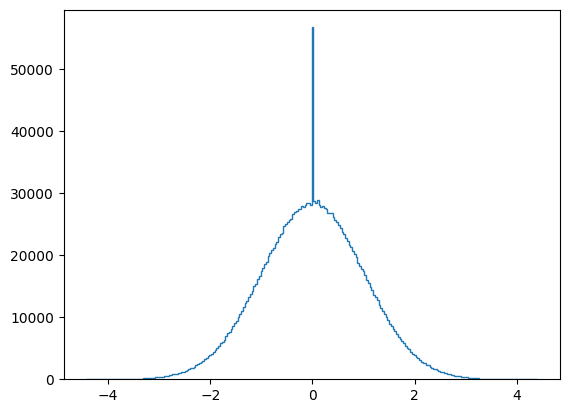

In [29]:
import matplotlib.pyplot as plt
sigma=np.std(data)
data=data/sigma
plt.hist(data,bins=256,histtype='step')
plt.show()

Looks fine, apart from +0 and -0 being folded into the same bin.

Now convert to complex

In [30]:
f=data.reshape([1024*1024,2])
print(f[0],f[0,0]**2+f[0,1]**2)
cdata = np.array([complex(*x) for x in f])
print(cdata[0],abs(cdata[0])**2)

[-0.83013411  0.69177842] 1.167680018340187
(-0.8301341058976776+0.691778421581398j) 1.167680018340187


Lets compute the 128k point DFTs before the the dechirp and look at one spectrum.  


(8, 131072)


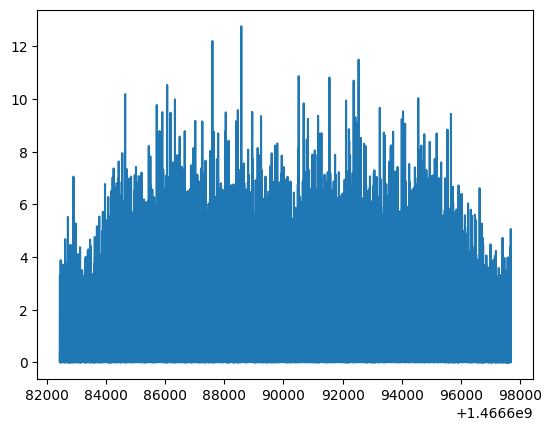

In [31]:
def fftarray(cdata,fft_len,subband_center=1466690063.4765625,sample_rate=15258.7890625):
    fft_len=int(fft_len)
    fft_output=abs(cdata)
    nsamples=len(cdata)
    nffts=int(nsamples/fft_len)
    fft_output=fft_output.reshape([nffts,fft_len])
    for i in range(nffts):
        fft_output[i,0:fft_len]=np.roll(abs(np.fft.fft(cdata[i*fft_len:(i+1)*fft_len]))**2,[int(-fft_len/2)])
    freq=np.roll(np.fft.fftfreq(fft_len, d=1.0/sample_rate)+subband_center,[int(-fft_len/2)])
    return fft_output,freq


fft_output, freq=fftarray(cdata,128*1024)
fft_output=fft_output/np.mean(fft_output)
print(fft_output.shape)
plt.plot(freq,fft_output[0])
plt.show()




Not much there.

Now rebin it to into the upper 15th of a 512x480 array using the maximum of the pixels.  This rebin_ndarray() function
could be rewritten to be faster.  Right now I'm worried about it being readable.

In [32]:


def rebin_2darray(ndarray, new_shape, operation='sum'):
    """
    Modified version of https://gist.github.com/derricw/95eab740e1b08b78c03f
    Rebins an ndarray in all axes based on the target shape, by summing or
        averaging, or local minimum/maximum.
    Dimnesions do not need to match an integer multiple
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg', 'min', 'max', 'median']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape) or ndarray.ndim != 2 or len(new_shape) !=2:
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))

    factor=np.array(ndarray.shape,dtype=np.float64)/np.array(new_shape,dtype=np.float64)
    newarray=np.zeros(new_shape,dtype=np.float64)
   
    for y in range(new_shape[0]):
        for x in range(new_shape[1]):
            ox=[int(x*factor[1]),int((x+1)*factor[1])]
            oy=[int(y*factor[0]),int((y+1)*factor[0])]
            if ox[1] == ox[0]:
                ox[1]=ox[0]+1
            if oy[1] == oy[0]:
                oy[1]=oy[0]+1
            if operation.lower() == "sum":
               v = np.sum(ndarray[oy[0]:oy[1],ox[0]:ox[1]])
            elif operation.lower() == "max":
               v = np.max(ndarray[oy[0]:oy[1],ox[0]:ox[1]])
            elif operation.lower() == "min":
               v = np.min(ndarray[oy[0]:oy[1],ox[0]:ox[1]])
            elif operation.loger() == "median":
               v = np.median(ndarray[oy[0]:oy[1],ox[0]:ox[1]])
            elif operation.lower() in ["mean", "average", "avg"]:
               v = np.average(ndarray[oy[0]:oy[1],ox[0]:ox[1]])
            newarray[y,x]=v
    return newarray



So in our spectra need to get rebinned into the top 1/15th of a 512x480 array, or 512x32

1.6644285772098435 15.742515513667819
(32, 1024)


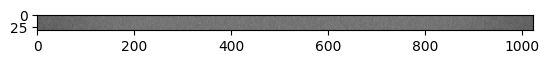

In [33]:
out=rebin_2darray(fft_output,[32,1024],operation='max')
plt.imshow(np.log(out/np.max(out)*255), cmap='gray', vmin=0, vmax=10)
print(np.min(out),np.max(out))
print(out.shape)

Now let's do all 12 DFT lengths....

In [44]:
def xshift(ndimage,dx):
    return np.roll(ndimage,dx,axis=1)

def make_fft_image(cdata,header,xsize=512,ysize=480):
    fft_length=128*1024
    subband_center=header['workunit_header']['subband_desc']['center']
    sample_rate=header['workunit_header']['subband_desc']['sample_rate']
    image=np.ndarray([ysize,xsize],dtype=np.float64)
    yindex=0.0
    yinc=ysize/15
    while fft_length > 4 :
        fft_output,freq=fftarray(cdata, fft_length, subband_center=subband_center, sample_rate=sample_rate)
        fft_output=fft_output/np.average(fft_output)
        fft_length=fft_length/2
        rebin=rebin_2darray(fft_output,[int(yinc),int(xsize)],operation='max')
        image[int(yindex):int(yindex+yinc),0:xsize]=np.maximum(rebin,image[int(yindex):int(yindex+yinc),0:xsize])
        yindex=yindex+yinc
    freq=np.arange(subband_center-sample_rate/2,subband_center+sample_rate/2,sample_rate/xsize)
    return image,freq

    

Now run and display it

1.1161821446885252


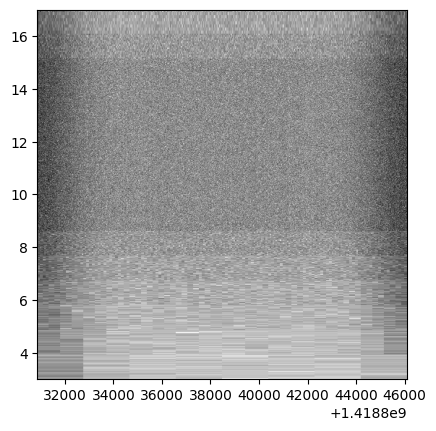

In [45]:
image,freq=make_fft_image(cdata,header)
print(np.min(image))
lim=np.log(image-np.min(image)+1)  # log scaline
lim=(lim-np.min(lim))/(np.max(lim)-np.min(lim))*255
plt.imshow(lim.astype(int), cmap='gray', vmin=0, vmax=255, extent=[np.min(freq),np.max(freq),3,17],aspect=(np.max(freq)-np.min(freq))/14)
plt.show()


Now lets generate our chirp...

In [36]:
def chirp_function(chirp_rate, sample_rate=15258.7890625, subband_center=1466690063.4765625, nsamples=1024*1024):
    # the chirp function is exp(-i*pi*chirp_rate*t^2)
    i=complex(0,1)
    t=np.arange(0.0,nsamples,1.0)/sample_rate
    # there may be some rounding error here.  It may be better to calculate this incrementally modulo 2*pi or to use the
    # integer indexes directly in a 128 bit integer type.
    chirp=np.exp(-i*np.pi*chirp_rate*t*t) 
    return chirp


    

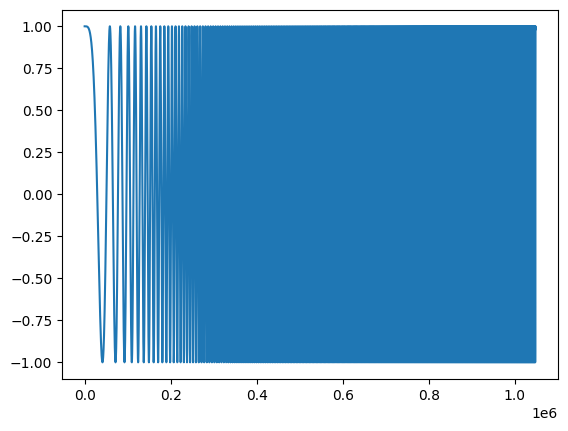

In [37]:
subband_center=header['workunit_header']['subband_desc']['center']
sample_rate=header['workunit_header']['subband_desc']['sample_rate']

chirp=chirp_function(np.float64(drift), sample_rate=sample_rate, subband_center=subband_center)
plt.plot(chirp.real)
plt.show()

Thes setiathome detection threshold for a signal is about 24 times the noise level in a 128k DFT, so lets add one with this chirp and redo the images.  That corresponds to a SNR in the unprocessed data 15 kHz data of 0.0135.

In [38]:
signal_data=cdata+0.0135*chirp

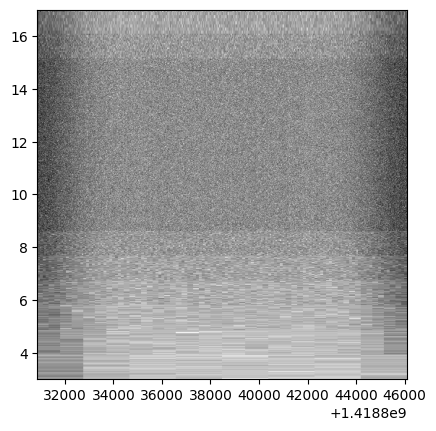

In [46]:
image,freq=make_fft_image(signal_data,header)
lim=np.log(image-np.min(image)+1)  # log scaline
lim=(lim-np.min(lim))/(np.max(lim)-np.min(lim))*255
plt.imshow(lim.astype(int), cmap='gray', vmin=0, vmax=255, extent=[np.min(freq),np.max(freq),3,17],aspect=(np.max(freq)-np.min(freq))/14)
plt.show()


It's not obvious.

Now let's dechirp.  The dechirp function is multiplying by the conjugate of the chirp function.

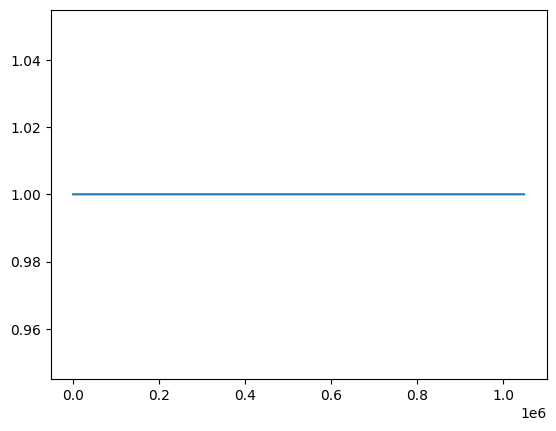

In [47]:
dechirped_data=signal_data*np.conj(chirp)
dechirped_chirp=chirp*np.conj(chirp)
plt.plot(dechirped_chirp)
plt.show()

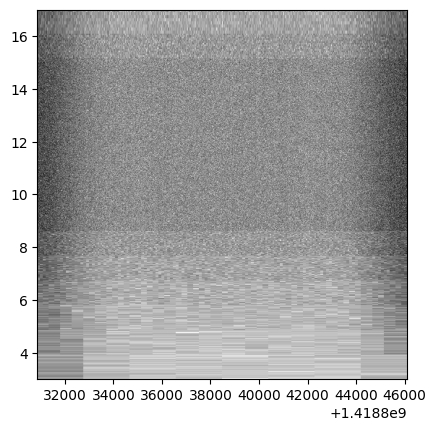

In [48]:
image,freq=make_fft_image(dechirped_data,header)
lim=np.log(image-np.min(image)+1)  # log scaline
lim=(lim-np.min(lim))/(np.max(lim)-np.min(lim))*255
plt.imshow(lim.astype(int), cmap='gray', vmin=0, vmax=255, extent=[np.min(freq),np.max(freq),3,17],aspect=(np.max(freq)-np.min(freq))/14)
plt.show()


Now you can see the signal, but only at the start of the 128k DFTS, the vertical line near the top (i.e. region 17).  It seems to be fading by the last DFT of that run, probably because of the floating point problem mentioned in the dechirp.  You can find ways to avoid that in the SETI@home source code.